## **Time series classification using tree-based methods**

#### **PromptTreeFit algorithm**

In [777]:
import numpy as np
import random
import pandas as pd
from sktime.datasets import load_from_tsfile_to_dataframe
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Trace 0:
Column: dim_0
  Channel dim_0: [1.5230845, 1.4849578, 1.458038, 1.4557316, 1.4537449, 1.4519495, 1.4506348, 1.4405691, 1.4043607, 1.3684378]
Label: 3
----
Trace 1:
Column: dim_0
  Channel dim_0: [1.6410278, 1.6040224, 1.5671336, 1.5306018, 1.5284477, 1.5617326, 1.5448334, 1.5101736, 1.4746884, 1.4395781]
Label: 0
----
Trace 2:
Column: dim_0
  Channel dim_0: [1.6410106, 1.6072935, 1.5736663, 1.5404056, 1.5074318, 1.4748995, 1.4422172, 1.4094309, 1.3768416, 1.3443055]
Label: 0
----


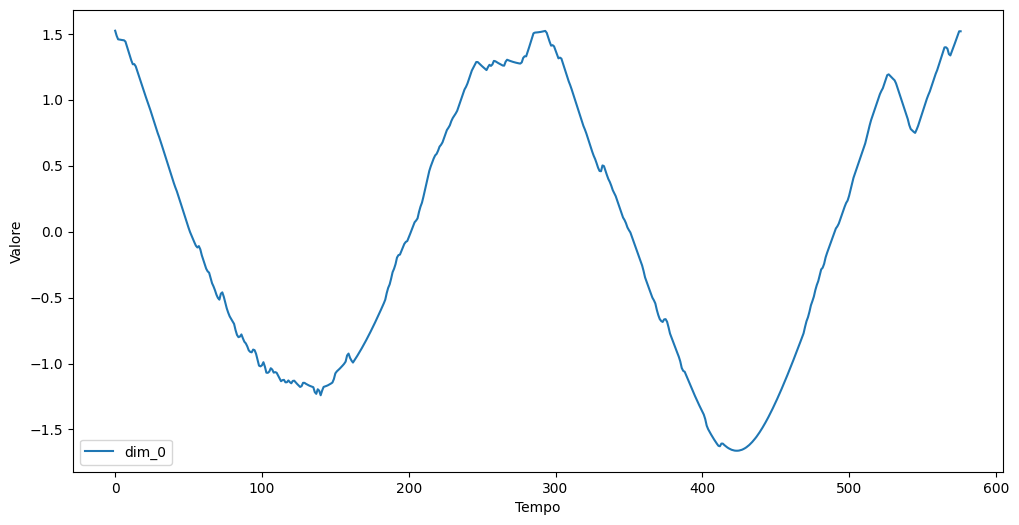

In [778]:
# Load .ts file
# X_train, y_train = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Multivariate_ts/BasicMotions/BasicMotions_TRAIN.ts")
# X_test, y_test = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Multivariate_ts/BasicMotions/BasicMotions_TEST.ts")

X_train, y_train = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Univariate_ts/Car/Car_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Univariate_ts/Car/Car_TEST.ts")

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Encoding label if necessary
le = LabelEncoder()
y_train = le.fit_transform(y_train) # fitto sui dati di train l'encoder, e poi trasformo e basta per val e test
y_val = le.transform(y_val)
y_test = le.transform(y_test)

for i in range(3):
	print(f"Trace {i}:")
	for col in X_train.columns:
		print("Column:", col)
		serie = X_train.iloc[i][col]
		print(f"  Channel {col}: {serie.head(10).tolist()}")
	print("Label:", y_train[i])
	print("----")


# Plot channels
sample = X_train.iloc[0]
plt.figure(figsize=(12, 6))
for col in sample.index:
	series = sample[col]  # pandas.Series con i valori temporali del canale
	plt.plot(series.values, label=col)
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.legend()
plt.show()

In [779]:
y_val

array([0, 3, 2, 1, 3, 1, 3, 0, 2, 1, 3, 0])

In [780]:
def euclidean_distance(x_slice, x_ref):
	x_ref_value = float(np.array(x_ref).flatten()[0])
	return np.sqrt(np.sum((x_slice - x_ref_value) ** 2))

def manhattan_distance(x_slice, x_ref):
	x_ref_value = float(np.array(x_ref).flatten()[0])
	return np.sum(np.abs(x_slice - x_ref_value))


def cosine_distance(x_slice, x_ref):
	"""
	Distanza coseno tra x_ref e x_slice trattata come vettore
	Se vuoi element-wise, considera x_ref broadcasted
	"""
	x_ref_value = float(np.array(x_ref).flatten()[0])
	x_slice_vec = np.array(x_slice)
	# coseno tra vettori: x_ref replicato
	dot = x_slice_vec * x_ref_value
	norm = np.linalg.norm(x_slice_vec) * np.linalg.norm([x_ref_value])
	return 1 - np.sum(dot) / (norm + 1e-9)


In [781]:
class Node():
	def __init__(self, x_barr, channel, bi, ei, df, t):
		self.x_barr = x_barr
		self.channel = channel
		self.begin_idx = bi
		self.end_idx = ei
		self.distance_f_node = df 
		self.threshold = t
		
		# figli
		self.node_dx = None # Node()
		self.node_sx = None # Node()

class LeafNode():
	def __init__(self, class_f):
		self.classification_f = class_f

In [782]:
class PromptTree():
	def __init__(self, X, y):
		# Require
		self.X = X
		self.y = y
		self.current_path = None # lista di dizionari
		self.distance_functions = self.get_distance_functions()
		
		values, counts = np.unique(y, return_counts=True)
		self.most_common_class = values[np.argmax(counts)] # use when leaf is not able to assign a class
		
		self.root = self.prompt_tree_fit_algo(self.X, self.y, self.current_path)
		
		# self.v = [] # vertices
		# self.e = [] # edges
		# self.s = [] # rst
		# self.l = [] # labels
		
	def prompt_tree_fit_algo(self, X, y, path):
		# print("\n==============================")
		# print("Inizio nuova ricorsione...")
		if path is None:
			path = []
			B = [0]
			E = [0]
		else:
			B, E = [], []
			for node in path:
				B.append(node.begin_idx)
				E.append(node.end_idx)

		# print("B (begin indices):", B)
		# print("E (end indices):", E)
		# print("Numero esempi a questo livello:", len(X))

		# Condizione di stop
		if self.stopping_f(path, X, y):
			
			if len(X) == 0: # quando non ha una previsione
				return LeafNode(None)
			
			leaf_class = self.classification_f(X, y)
			# print(f"FOGLIA trovata! Classificazione: {leaf_class}")
			return LeafNode(leaf_class)

		# Candidate intervals
		candidate_intervals = self.promptness_f(X, y, B, np.max(E) + 1)
		# print("Candidate intervals:", candidate_intervals)

		# Candidate tests
		candidate_tests = self.sampling_f(X, y, candidate_intervals)
		# print("Candidate tests:", candidate_tests)

		# Optimal candidate
		optimal_candidate, df_true, df_false = self.optimization_f(X, y, candidate_tests)
		# print("Optimal candidate selezionato:", optimal_candidate)

		# Recupero valori del nodo
		x_barr, c, begin_idx, end_idx, dist_f, threshold = (
			optimal_candidate[k] for k in ['x_barr', 'channel', 'b', 'e', 'dist_fun', 'threshold']
		)

		# Creazione nodo
		node = Node(x_barr, c, begin_idx, end_idx, dist_f, threshold)
		# print(f"NODO creato: channel={c}, begin={begin_idx}, end={end_idx}, threshold={threshold}")
		# print(f"x_barr={x_barr}")

		# Preparazione dati per i rami sinistro e destro
		X_true = pd.DataFrame([x for x, _ in df_true], columns=X.columns)
		y_true = np.array([label for _, label in df_true])
		X_false = pd.DataFrame([x for x, _ in df_false], columns=X.columns)
		y_false = np.array([label for _, label in df_false])
		# print(f"Esempi ramo LEFT (<= threshold): {len(X_true)}, RIGHT (> threshold): {len(X_false)}")

		# Ricorsione ramo sinistro
		# print("=== Ricorsione ramo LEFT ===")
		path_true = path.copy()
		path_true.append(node)
		node.node_sx = self.prompt_tree_fit_algo(X_true, y_true, path_true)

		# Ricorsione ramo destro
		# print("=== Ricorsione ramo RIGHT ===")
		path_false = path.copy()
		path_false.append(node)
		node.node_dx = self.prompt_tree_fit_algo(X_false, y_false, path_false)

		# print(f"Ritorno nodo channel={c} a livello superiore")
		return node

			
	def post_pruning(self, node=None, X_val=None, y_val=None):
		"""
		Potatura post-training usando un set di validazione.
		Se chiamato senza nodo, parte dalla radice e aggiorna self.root.
		"""
		if node is None:
			node = self.root

		if isinstance(node, LeafNode):
			return node, y_val

		# Prima divido il set di validazione secondo il test del nodo
		X_true, y_true = self.split_validation(node, X_val, y_val, True)
		X_false, y_false = self.split_validation(node, X_val, y_val, False)

		# Ricorsione sui figli
		node.node_sx, left_labels = self.post_pruning(node.node_sx, X_true, y_true)
		node.node_dx, right_labels = self.post_pruning(node.node_dx, X_false, y_false)

		# Weighted error dei figli
		total = len(left_labels) + len(right_labels)
		if total == 0:
			err_backed_up = 0
			err_leaf = 0
			random_label = random.choice(y_val)
			most_common = random_label
		else:
			err_backed_up = (len(left_labels)/total) * self.node_error(node.node_sx, left_labels) + \
						(len(right_labels)/total) * self.node_error(node.node_dx, right_labels)

			# Errore se nodo diventa foglia
			combined_labels = np.concatenate([left_labels, right_labels]).astype(int)
			most_common = np.bincount(combined_labels).argmax()
			err_leaf = np.mean(combined_labels != most_common)
		
		if err_leaf <= err_backed_up:
			# Nodo potato a foglia
			leaf = LeafNode({most_common: 1.0})
			return leaf, combined_labels
		else:
			return node, combined_labels

	def prune(self, X_val, y_val):
		"""
		Funzione pubblica: applica post_pruning e aggiorna la radice.
		"""
		self.root, _ = self.post_pruning(self.root, X_val, y_val)
		return self  # ritorna il PromptTree potato

	def split_validation(self, node, X_val, y_val, go_left):
		"""
		Applica il test del nodo su X_val e y_val per ottenere sottoinsiemi True/False.
		"""
		X_sub = []
		y_sub = []

		# Funzione interna che valuta il test del nodo su un singolo sample
		def passes_node_test(node, x):
			# print("NNNNNN", x)
			slice_x = x[node.channel][node.begin_idx:node.end_idx]
			dist = node.distance_f_node(slice_x, node.x_barr)
			return dist <= node.threshold

		for i, (idx, x) in enumerate(X_val.iterrows()):
			# print("DDD",x)
			if go_left and passes_node_test(node, x):
				X_sub.append(x)
				y_sub.append(y_val[i])
			elif not go_left and not passes_node_test(node, x):
				X_sub.append(x)
				y_sub.append(y_val[i])
		
		X_sub = pd.DataFrame(X_sub, index=range(len(X_sub)))
		return X_sub, np.array(y_sub)

	def node_error(self, node, labels):
		if isinstance(node, LeafNode):
			if node.classification_f is not None:
				cls = list(node.classification_f.keys())[0]
				return np.mean(labels != cls)
			else:
				return 0
		else:
			return 0
	
	def get_pruned_tree(self, X_val, y_val):
		"""
		Restituisce un nuovo PromptTree potato senza modificare self.root.
		"""
		new_root, _ = self.post_pruning(self.root, X_val, y_val)
		new_tree = PromptTree.__new__(PromptTree)  # crea nuova istanza senza __init__
		new_tree.X = self.X
		new_tree.y = self.y
		new_tree.root = new_root
		return new_tree
	
	def get_paths_of_tree(Self):
		pass


	def promptness_f(self, X, y, B, max_e):
		''' Propone un set di coppie: canale, intervallo'''
		total_pairs = random.randint(1, len(B)//2 + 1)
		pairs = []
		
		channels = list(X.columns) # get channels
		k = random.randint(1, len(channels)) # 
		selected_channels = random.sample(channels, k) # select some channels inside channels
		
		for channel in selected_channels: # loop over selected channels
			for i in range(total_pairs):
				b = random.randrange(B[0], max_e)
				# print(b, max_e)
				pair = {'channel': channel, "interval": (b, max_e)}
				pairs.append(pair)
		return pairs

	def sampling_f(self, X, y, candidate_intervals):
		candidate_tests = []
		for candidate in candidate_intervals:
			# generare un test candidate, per cui aggiungo threshold, distance function
			channel = candidate['channel']
			b = candidate['interval'][0]
			e = candidate['interval'][1]
			dist_fun = random.choice(self.distance_functions)
			threshold = random.uniform(0,2)
			
			# seleziono il sample di riferimento considerando self.X come un dataframe, forse devo fare un for
			ref_idx = np.random.randint(0, X.shape[0]) # selezione l'indice del sample random
			cols = [col for col in X.columns if col.startswith(channel)] # estrapolo solo le colonne relative al canale
			x_barr = X.iloc[ref_idx][cols].apply(lambda s: s[b:e]).values # seleziono le colonne del canale per quel sample, estraggo l’intervallo [b:e] da ogni serie, 
																		  # .values converte in array NumPy, pronto per calcolare la distanza
			
			candidate_test = { 'x_barr': x_barr,
							   'channel' : channel, 
							   'b': b,
							   'e' : e, 
							   'dist_fun' : dist_fun, 
							   'threshold' : threshold}
			candidate_tests.append(candidate_test)
		return candidate_tests
	
	def optimization_f(self, X, y, candidate_tests):
		entropy_test = 1000
		df_true = None
		df_false = None
		for candidate in candidate_tests:
			candidate_tests_true = []
			candidate_tests_false = []
			# print("Candidate:", candidate)
			for i, (idx, row) in enumerate(X.iterrows()):
				# print("Row:", row)
				# col = [col for col in X.columns if col.startswith(candidate['channel'])]
				col = candidate['channel']
				# print("Col:", col)
				slice_x = row[col].iloc[candidate['b']:candidate['e']].values # slice all'interno della riga
				# print("Slice len:", len(slice_x))
				# print("Candidate x_barr:", candidate['x_barr'])
				# print("Slice x:", slice_x)
				# if candidate['e'] > len(slice_x): # CONTROLLARE PERCHE' NON PUO' ESSERE PIU GRANDE END_INDEX
				# 	# print(f"Warning: candidate['e']={candidate['e']} > slice length={len(slice_x)}")
				# 	continue
				dist = np.mean(candidate['dist_fun'](slice_x, candidate['x_barr'])) # calcola la distanze di ogni elemento del mio slice da x_barr, dopodichè faccio la media cosi ottengo solo 1 valore
				# print("Dist:", dist)
				
				if (dist <= candidate['threshold']):
					candidate_tests_true.append((row, y[i])) # tutto il sample con la sua label va nel ramo true
				else:
 					candidate_tests_false.append((row, y[i]))
			
			# mi tengo solo le label
			y_true = [label for _, label in candidate_tests_true] # passo tutte le etichette di entrambi i subset
			y_false = [label for _, label in candidate_tests_false]
			
			# print("Y_TRUE:", y_true)
			# print("Y_FALSE:", y_false)
			current_entropy = self.calculate_entropy(y_true, y_false)
			if (current_entropy < entropy_test): # calcolo l'entropia sulle label
				best_test_candidate = candidate
				entropy_test = current_entropy
				df_true = candidate_tests_true
				df_false = candidate_tests_false
		return best_test_candidate, df_true, df_false
		# x_barr, c, begin_idx, end_idx, dist_f, threshold
		
	def entropy(self, labels):
		from collections import Counter
		import math
		n = len(labels)
		if n == 0:
			return 0.0
		counts = Counter(labels)
		probs = [c/n for c in counts.values()]
		return -sum(p * math.log2(p) for p in probs if p > 0)
	
	def calculate_entropy(self, y_true, y_false):
		n_true = len(y_true)
		n_false = len(y_false)
		total = n_true + n_false
		H_true = self.entropy(y_true)
		H_false = self.entropy(y_false)
		H_total = (n_true/total) * H_true + (n_false/total) * H_false
		return H_total

	def classification_f(self, X, y):
		# Ritorna distribuzione semplice delle classi
		classes, counts = np.unique(y, return_counts=True)
		distr = {cls: cnt/len(y) for cls, cnt in zip(classes, counts)}
		return distr
	
	def stopping_f(self, path, X, y):
		"""
		Stop quando l'entropia è zero
		(cioè tutti i campioni appartengono alla stessa classe).
		"""
		if len(y) == 0:  # non ho label, return true
			return True
		
		# Calcola distribuzione delle classi
		_, counts = np.unique(y, return_counts=True)

		# Se c'è solo una classe, vuol dire che l'entropia è zero, non ho incertezza
		return len(counts) == 1
	
	def get_distance_functions(self):
		return [euclidean_distance, manhattan_distance, cosine_distance]

# --------------------------

# Create prompt_tree
prompt_tree = PromptTree(X_train, y_train)

def print_tree(node, prefix=""):
	"""Stampa ricorsiva di Node e LeafNode in modo leggibile"""
	if isinstance(node, LeafNode):
		print(f"{prefix}└── Leaf: class={node.classification_f}")
		return
	elif isinstance(node, Node):
		print(f"{prefix}└── Node: channel={node.channel}, x_barr={node.x_barr.flatten()}, "
			  f"begin={node.begin_idx}, end={node.end_idx}, threshold={node.threshold}")
		
		if node.node_sx is not None or node.node_dx is not None:
			# Determina i prefissi per sinistro e destro
			if node.node_sx is not None:
				print(f"{prefix}    Left:")
				print_tree(node.node_sx, prefix + "        ")
			if node.node_dx is not None:
				print(f"{prefix}    Right:")
				print_tree(node.node_dx, prefix + "        ")

In [783]:
def predict(tree, x, default_class=None):
	"""
	Naviga l'albero e restituisce la classe più probabile.
	"""
	if isinstance(tree, Node):
		return 0
	# print(tree)
	node = tree.root
	while isinstance(node, Node):
		# seleziona l'intervallo del canale
		slice_x = x[node.channel][node.begin_idx:node.end_idx]

		# calcola distanza media dal riferimento
		dist = np.mean(node.distance_f_node(slice_x, node.x_barr))

		if dist <= node.threshold:
			node = node.node_sx  # ramo True
		else:
			node = node.node_dx  # ramo False

	# siamo in una foglia
	if not node.classification_f:  # caso foglia vuota
		# print("FOGLIA VUOTA")
		return default_class
	
	# prendi la classe con frequenza massima
	return max(node.classification_f.items(), key=lambda kv: kv[1])[0]


# print_tree(prompt_tree.root)
y_pred = [predict(prompt_tree, x, default_class=0) for _, x in X_test.iterrows()]
accuracy = round(sum(y_pred_i == y_true_i for y_pred_i, y_true_i in zip(y_pred, y_test)) / len(y_test), 3)
print("Accuracy:", accuracy)

Accuracy: 0.283


In [784]:
# # Post-pruning
# pruned_tree = prompt_tree.get_pruned_tree(X_val, y_val)
# print_tree(pruned_tree.root)
# y_pred = [predict(pruned_tree, x, default_class=0) for _, x in X_test.iterrows()]
# accuracy = round(sum(y_pred_i == y_true_i for y_pred_i, y_true_i in zip(y_pred, y_test)) / len(y_test), 3)
# print("Accuracy:", accuracy)

#### **Random Forest**

Accuracy majority voting: 0.333
First 5 prediction probabilities (majority): [{1: 0.8333333333333334, 2: 0.16666666666666666}, {0: 0.8333333333333334, 1: 0.16666666666666666}, {1: 0.8333333333333334, 3: 0.16666666666666666}, {0: 0.3333333333333333, 2: 0.6666666666666666}, {1: 0.3333333333333333, 3: 0.5, 2: 0.16666666666666666}]
Classification Report (majority voting):
               precision    recall  f1-score   support

           0       0.18      0.21      0.19        14
           1       0.32      0.57      0.41        14
           2       0.55      0.32      0.40        19
           3       0.43      0.23      0.30        13

    accuracy                           0.33        60
   macro avg       0.37      0.33      0.33        60
weighted avg       0.38      0.33      0.33        60



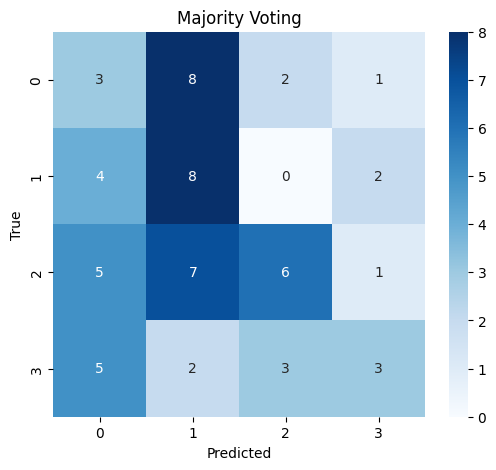

Accuracy weighted voting: 0.35
First 5 prediction probabilities (weighted): [{1: 0.8214285714285714, 2: 0.17857142857142858}, {0: 0.8214285714285714, 1: 0.17857142857142858}, {1: 0.8214285714285714, 3: 0.17857142857142858}, {0: 0.39285714285714285, 2: 0.6071428571428572}, {1: 0.2857142857142857, 3: 0.5357142857142857, 2: 0.17857142857142858}]
Classification Report (weighted voting):
               precision    recall  f1-score   support

           0       0.19      0.21      0.20        14
           1       0.32      0.57      0.41        14
           2       0.55      0.32      0.40        19
           3       0.50      0.31      0.38        13

    accuracy                           0.35        60
   macro avg       0.39      0.35      0.35        60
weighted avg       0.40      0.35      0.35        60



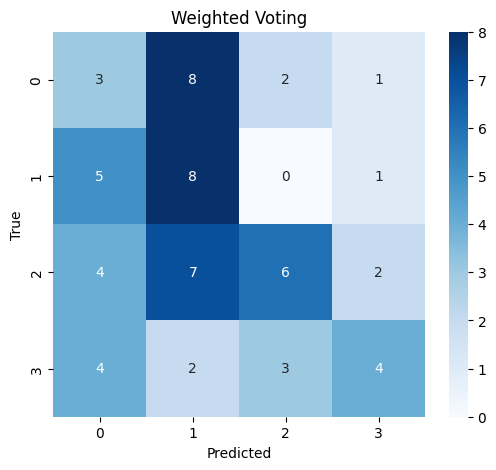

Accuracy track record voting: 0.333
First 5 prediction probabilities (track record): [{1: 0.8421052631578948, 2: 0.15789473684210525}, {0: 0.8571428571428571, 1: 0.14285714285714285}, {1: 0.9142857142857143, 3: 0.0857142857142857}, {0: 0.0, 2: 1.0}, {1: 0.4, 3: 0.4, 2: 0.2}]
Classification Report (track record voting):
               precision    recall  f1-score   support

           0       0.23      0.21      0.22        14
           1       0.27      0.57      0.36        14
           2       0.67      0.32      0.43        19
           3       0.38      0.23      0.29        13

    accuracy                           0.33        60
   macro avg       0.38      0.33      0.33        60
weighted avg       0.41      0.33      0.33        60



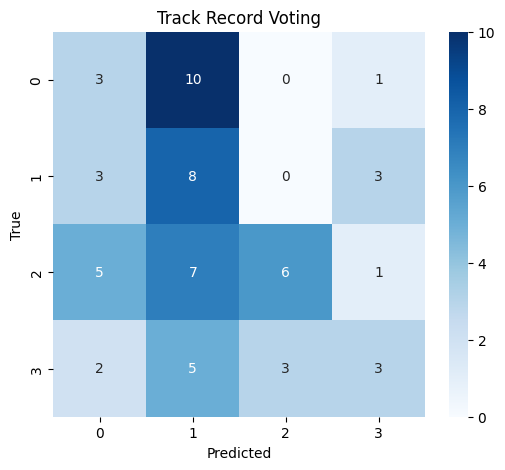


RF weights for each tree: {0: 0.17857142857142858, 1: 0.21428571428571427, 2: 0.14285714285714285, 3: 0.10714285714285714, 4: 0.17857142857142858, 5: 0.17857142857142858}

RF track records for each tree: {0: {0: 0.0, 3: 0.5, 2: 0.0, 1: 1.0}, 1: {0: 0.0, 3: 0.5, 2: 0.5, 1: 1.0}, 2: {0: 0.6666666666666666, 3: 0.25, 2: 0.0, 1: 0.3333333333333333}, 3: {0: 0.6666666666666666, 3: 0.25, 2: 0.0, 1: 0.0}, 4: {0: 0.3333333333333333, 3: 0.5, 2: 0.5, 1: 0.3333333333333333}, 5: {0: 0.6666666666666666, 3: 0.25, 2: 0.5, 1: 0.3333333333333333}}


In [785]:
class RandomForest():
	def __init__(self, n_trees, X_train, y_train, X_val, y_val, X_test, y_test):
		self.number_of_trees = n_trees
		self.X_train = X_train
		self.y_train = y_train
		self.X_val = X_val
		self.y_val = y_val
		self.X_test = X_test
		self.y_test = y_test

		# solo per conformal classifier
		self.X_cal = X_val
		self.y_cal = y_val

		self.trees = self.create_trees()

		# dizionari per salvare pesi e track record
		self.weights_random_forest = None
		self.track_records_random_forest = None

	def create_trees(self):
		trees = {}
		for i in range(self.number_of_trees):
			tree = PromptTree(self.X_train, self.y_train)
			trees[i] = tree
		return trees 
	
	def predict_only(self, X):
		"""
		Restituisce:
		  - y_probs_final: lista di dizionari con la distribuzione finale combinata di tutti gli alberi
		  - y_probs_per_tree: lista di liste di dizionari, ciascuna sotto-lista contiene le distribuzioni di probabilità
			di ciascun albero per un campione
		"""
		y_probs_final = []
		y_probs_per_tree = []  # lista di liste

		for _, x in X.iterrows():
			class_scores = {}
			probs_per_tree = []

			for tree in self.trees.values():
				pred = predict(tree, x, default_class=0)
				# Ogni albero restituisce solo 1 probabilità 1 per la predetta e 0 per le altre
				probs_tree = {pred: 1.0}  # dizionario con predizione dell'albero
				probs_per_tree.append(probs_tree)

				# accumula punteggio per combinazione finale
				class_scores[pred] = class_scores.get(pred, 0) + 1

			# Normalizzazione in probabilità finale
			total_score = sum(class_scores.values())
			probs_final = {cls: score / total_score for cls, score in class_scores.items()}

			y_probs_final.append(probs_final)
			y_probs_per_tree.append(probs_per_tree)

		return y_probs_final, y_probs_per_tree


	def majority_voting(self, X, return_probs=False):
		y_final_pred = []
		y_probs = [] 
		for _, x in X.iterrows():
			class_votes = {}
			for tree in self.trees.values():
				pred = predict(tree, x, default_class=0)
				class_votes[pred] = class_votes.get(pred, 0) + 1
			
			# predizione finale
			final_cls = max(class_votes.items(), key=lambda kv: kv[1])[0]
			y_final_pred.append(final_cls)
			
			if return_probs:
				total_votes = sum(class_votes.values())
				probs = {cls: v/total_votes for cls, v in class_votes.items()}
				y_probs.append(probs)
		
		accuracy_test = sum(p == t for p, t in zip(y_final_pred, self.y_test)) / len(self.y_test)
		if return_probs:
			return round(accuracy_test, 3), y_final_pred, y_probs
		else:
			return round(accuracy_test, 3)

	def weighted_voting(self, X_val, y_val, X_test, y_test, return_probs=False):
		# Calcolo le accuracy in validation per ogni tree
		accuracies_val = {}
		for i, tree in self.trees.items():
			y_pred = [predict(tree, x, default_class=0) for _, x in X_val.iterrows()]
			acc = sum(y_pred_i == y_true_i for y_pred_i, y_true_i in zip(y_pred, y_val)) / len(y_val)
			accuracies_val[i] = acc

		# Normalizzo
		total = sum(accuracies_val.values())
		if total == 0:
			weights = {i: 1/len(self.trees) for i in self.trees}
		else:
			weights = {i: acc/total for i, acc in accuracies_val.items()}

		# Salvo i pesi nella variabile di istanza
		self.weights_random_forest = weights

		# Final prediction pesata
		y_final_pred = []
		y_probs = []
		for _, x in X_test.iterrows():
			class_scores = {}
			for i, tree in self.trees.items():
				pred = predict(tree, x, default_class=0)
				class_scores[pred] = class_scores.get(pred, 0) + weights[i]

			final_cls = max(class_scores.items(), key=lambda kv: kv[1])[0]
			y_final_pred.append(final_cls)

			if return_probs:
				total_score = sum(class_scores.values())
				probs = {cls: s/total_score for cls, s in class_scores.items()}
				y_probs.append(probs)

		accuracy_test = sum(p == t for p, t in zip(y_final_pred, y_test)) / len(y_test)
		if return_probs:
			return round(accuracy_test, 3), y_final_pred, y_probs
		else:
			return round(accuracy_test, 3)

	def track_record_voting(self, X_val, y_val, X_test, y_test, return_probs=True):
		# Ogni tree accumula un record di performance su un validation set
		accuracies_val_for_tree = {}
		for i, tree in self.trees.items():
			class_correct = {}
			class_total = {}

			for idx, (_, x) in enumerate(X_val.iterrows()):
				y_pred_i = predict(tree, x, default_class=0)
				y_true_i = y_val[idx]

				# incremento i conteggi per la classe vera
				class_total[y_true_i] = class_total.get(y_true_i, 0) + 1
				if y_pred_i == y_true_i:
					class_correct[y_true_i] = class_correct.get(y_true_i, 0) + 1

			# salvo accuracies per classe
			accuracies_val_for_tree[i] = {
				cls: class_correct.get(cls, 0) / total for cls, total in class_total.items()
			}

		# Salvo il track record nella variabile di istanza
		self.track_records_random_forest = accuracies_val_for_tree

		# Final prediction
		y_final_pred = []
		y_probs = []
		for _, x in X_test.iterrows():
			class_scores = {}
			for i, tree in self.trees.items():
				pred = predict(tree, x, default_class=0)
				weight = accuracies_val_for_tree[i].get(pred, 0)
				class_scores[pred] = class_scores.get(pred, 0) + weight

			final_cls = max(class_scores.items(), key=lambda kv: kv[1])[0]
			y_final_pred.append(final_cls)

			if return_probs:
				total_score = sum(class_scores.values())
				if total_score == 0:
					# Distribuisci uniformemente le probabilità tra tutte le classi
					n_classes = len(class_scores)
					probs = {cls: 1/n_classes for cls in class_scores}
				else:
					probs = {cls: s/total_score for cls, s in class_scores.items()}
				y_probs.append(probs)


		accuracy_test = sum(p == t for p, t in zip(y_final_pred, y_test)) / len(y_test)
		if return_probs:
			return round(accuracy_test, 3), y_final_pred, y_probs
		else:
			return round(accuracy_test, 3)


		
n_trees = 6
random_forest = RandomForest(n_trees, X_train, y_train, X_val, y_val, X_test, y_test)

return_probs = True

# Funzione per plottare la confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
	cm = confusion_matrix(y_true, y_pred)
	plt.figure(figsize=(6,5))
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
	plt.xlabel("Predicted")
	plt.ylabel("True")
	plt.title(title)
	plt.show()

# Majority vote
acc_maj, y_pred_maj, y_probs_maj = random_forest.majority_voting(random_forest.X_test, return_probs=return_probs)
print("Accuracy majority voting:", acc_maj)
print("First 5 prediction probabilities (majority):", y_probs_maj[:5])
print("Classification Report (majority voting):\n", classification_report(random_forest.y_test, y_pred_maj))
plot_confusion_matrix(random_forest.y_test, y_pred_maj, title="Majority Voting")

# Weighted vote
acc_wei, y_pred_wei, y_probs_wei = random_forest.weighted_voting(
	random_forest.X_val, random_forest.y_val,
	random_forest.X_test, random_forest.y_test,
	return_probs=return_probs
)
print("Accuracy weighted voting:", acc_wei)
print("First 5 prediction probabilities (weighted):", y_probs_wei[:5])
print("Classification Report (weighted voting):\n", classification_report(random_forest.y_test, y_pred_wei))
plot_confusion_matrix(random_forest.y_test, y_pred_wei, title="Weighted Voting")

# Track record vote
acc_tr, y_pred_tr, y_probs_tr = random_forest.track_record_voting(
	random_forest.X_val, random_forest.y_val,
	random_forest.X_test, random_forest.y_test,
	return_probs=return_probs
)
print("Accuracy track record voting:", acc_tr)
print("First 5 prediction probabilities (track record):", y_probs_tr[:5])
print("Classification Report (track record voting):\n", classification_report(random_forest.y_test, y_pred_tr))
plot_confusion_matrix(random_forest.y_test, y_pred_tr, title="Track Record Voting")

# Mostra pesi e track record dei singoli alberi
print("\nRF weights for each tree:", random_forest.weights_random_forest)
print("\nRF track records for each tree:", random_forest.track_records_random_forest)

#### **Conformal classifier**

In [786]:
# Load .ts file
# X_train, y_train = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Multivariate_ts/BasicMotions/BasicMotions_TRAIN.ts")
# X_test, y_test = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Multivariate_ts/BasicMotions/BasicMotions_TEST.ts")

X_train, y_train = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Univariate_ts/Car/Car_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("C:/Users/Simone/Desktop/UNIVERSITA/MAGISTRALE/BIOMEDICAL DECISION SUPPORT SYSTEM/Univariate_ts/Car/Car_TEST.ts")

X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Encoding label if necessary
le = LabelEncoder()
y_train = le.fit_transform(y_train) # fitto sui dati di train l'encoder, e poi trasformo e basta per val e test
y_cal = le.transform(y_cal)
y_test = le.transform(y_test)

In [787]:
print(random_forest.predict_only(X_cal)[1][0]) # vedo la predizione di ogni albero, quindi label=3 con prob=0.6 per esempio

[{3: 1.0}, {3: 1.0}, {0: 1.0}, {1: 1.0}, {0: 1.0}, {0: 1.0}]


In [788]:
print(random_forest.predict_only(X_cal)[0][11])

{2: 0.3333333333333333, 3: 0.16666666666666666, 0: 0.5}


In [792]:
class ConformalClassifier:
	def __init__(self, classifier, voting="majority", alpha=0.1):
		"""
		classifier: istanza della tua RandomForest
		voting: "majority", "weighted", "track_record"
		"""
		self.classifier = classifier
		self.voting = voting
		self.alpha = alpha

	def get_pred_probs_calibration(self):
		"""
		Ritorna le predizioni probabilistiche sul set di calibrazione
		secondo il meccanismo di voting scelto.
		"""
		X_cal = self.classifier.X_cal 
		y_cal = self.classifier.y_cal
		y_probs = []
		
		y_cal_preds_probs, y_cal_preds_probs_per_tree = self.classifier.predict_only(X_cal)

		if self.voting == "majority":
			probs = y_cal_preds_probs
		elif self.voting == "weighted":
			# best_pred_for_each_sample = []
			final_probs = []
			for pred_prob_per_tree in y_cal_preds_probs_per_tree: # itero sulle predizioni per ogni sample
				combined_scores = {}
				for idx_of_tree, tree_probs in enumerate(pred_prob_per_tree):
					# print(str(tree_probs) + " ---- " + str(idx_of_tree))
					for label, prob in tree_probs.items():
					# print(self.classifier.weights_random_forest)
						tree_weight = self.classifier.weights_random_forest[idx_of_tree] # peso dell'albero
						combined_scores[label] = combined_scores.get(label, 0) + prob * tree_weight
				total_score = sum(combined_scores.values())
				if total_score > 0:
					normalized_scores = {cls: score / total_score for cls, score in combined_scores.items()}
				else:
					normalized_scores = {cls: 0 for cls in combined_scores}

				# tengo solo la predizione con prob massima
				# best_pred = max(normalized_scores.items(), key=lambda kv: kv[1])
				# best_pred = {best_pred[0]: best_pred[1]}
				# best_pred_for_each_sample.append(best_pred)
				final_probs.append(normalized_scores)
			probs = final_probs
		elif self.voting == "track_record":
			# best_pred_for_each_sample = []
			final_probs = []
			for pred_prob_per_tree in y_cal_preds_probs_per_tree:  # itero sulle predizioni per ogni sample
				combined_scores = {}
				for idx_of_tree, tree_probs in enumerate(pred_prob_per_tree):  # per ogni albero
					for label, prob in tree_probs.items():
						# prendo il peso dal track record dell'albero per quella classe
						tree_record = self.classifier.track_records_random_forest[idx_of_tree]
						class_weight = tree_record.get(label, 0)  # prendo il peso relativo alla classe specifica, se quella classe non era mai stata vista → 0
						combined_scores[label] = combined_scores.get(label, 0) + prob * class_weight
				
				# normalizzazione dei punteggi per ottenere distribuzione di probabilità
				total_score = sum(combined_scores.values())
				if total_score > 0:
					normalized_scores = {cls: score / total_score for cls, score in combined_scores.items()}
				else:
					normalized_scores = {cls: 0 for cls in combined_scores}
			
				# tengo solo la predizione con prob massima
				# best_pred = max(normalized_scores.items(), key=lambda kv: kv[1])
				# best_pred = {best_pred[0]: best_pred[1]}
				# best_pred_for_each_sample.append(best_pred)
				final_probs.append(normalized_scores)
			probs = final_probs
		else:
			raise ValueError("Voting must be 'majority', 'weighted' or 'track_record'")
		# print(probs)
		# print(len(probs))
		return probs, y_cal

	def conformal_predict(self):
		"""
		Calcola le predizioni conformi sul test set.
		Ritorna una lista di liste: classi conformi per ogni sample.
		"""
		# Calcolo predizioni probabilistiche sul set di calibrazione
		pred_probs_cal, y_cal = self.get_pred_probs_calibration()

		# Calcolo i non-conformity scores
		nc_scores = []
		for i, probs in enumerate(pred_probs_cal):
			true_class = y_cal[i] # questa è la vera label, la vera classe
			# print(true_class, i, probs)
			nc_score = 1 - probs.get(true_class, 0) # capisco quanto la mia predizione della classe vera si discosta dalla predizione della classe vera del dataset
			nc_scores.append(nc_score)
		# print("\nNC scores", nc_scores)
		# print(len(nc_scores))

		# Calcolo il threshold di conformità
		threshold = np.quantile(nc_scores, 1 - self.alpha)

		# Predizione su X_test
		y_conformal = []
		# for _, x in X_test.iterrows():
		# Ottengo probabilità predette dal modello
		if self.voting == "majority":
			_, _, probs_test = self.classifier.majority_voting(self.classifier.X_test, return_probs=True)
		elif self.voting == "weighted":
			_, _, probs_test = self.classifier.weighted_voting(self.classifier.X_val, self.classifier.y_val, self.classifier.X_test, self.classifier.y_test, return_probs=True)
		elif self.voting == "track_record":
			_, _, probs_test = self.classifier.track_record_voting(self.classifier.X_val, self.classifier.y_val, self.classifier.X_test, self.classifier.y_test, return_probs=True)

		# Conformal set per questo sample
		# probs_test è lista di dict, un dict per sample contenente tutte le label e le relative probabilità
		# print(probs_test)
		for i, sample_probs in enumerate(probs_test):  # iteriamo su ogni sample
			conformal_set = [
				cls
				for cls, p in sample_probs.items() # prendo la classe/label e la probabilità relativa
				if (1 - p) <= threshold # memorizzo la classe nel conformal set solo se > threshold
			]

			# Evita duplicati (non necessario se sample_probs è già un dict)
			y_conformal.append(conformal_set)

		return y_conformal
		
	def calibrate(self, alpha=0.1):
		y_conformal = self.conformal_predict() # miscalibration=coverage desiderata−coverage osservata
		
		# Coverage desiderata
		confidence = 1 - alpha
		
		# Efficiency = percentuale di sample con solo 1 classe conforme
		efficiency = sum(len(c) == 1 for c in y_conformal) / len(y_conformal)
		
		# Coverage osservata: quante volte la vera classe è nell'insieme conforme
		coverage_observed = sum(
			true_label in conf_classes
			for true_label, conf_classes in zip(self.classifier.y_cal, y_conformal)
		) / len(y_conformal)
		
		# Miscalibration
		miscalibration = confidence - coverage_observed
		
		return confidence, efficiency, miscalibration

	
####### 
#######

#### DEFINE PARAMETERS ####
n_trees = 5
voting = 'weighted'
alpha = 0.1  # livello di significatività: 1-alpha = livello di confidenza

#### CREATE CONFORMAL CLASSIFIER ####
conformal_classifier = ConformalClassifier(random_forest, voting, alpha)
confidence, efficiency, miscalibration = conformal_classifier.calibrate()
print(f"\nConfidence: {confidence*100:.1f}%")
print(f"Efficiency: {efficiency*100:.1f}%")
print(f"Miscalibration: {miscalibration*100:.1f}%")



Confidence: 90.0%
Efficiency: 8.3%
Miscalibration: 81.7%


#### **Unsupervised learning**